_以下代碼是在 Sagemaker 中運行，所以要先上傳腳本_

# 安裝套件

In [1]:
%%capture
!python -m pip install --upgrade pip boto3 scikit-learn sagemaker nltk seaborn

# 魔法方法

%%capture 隱藏輸出

# 快速鍵

DD 刪除當前 Cell

A 在當前 Cell 上方添加 Cell

B 在當前 Cell 下方添加 Cell

C 複製當前 Cell

V 貼上複製的 Cell

M 將當前 Cell 轉換為 Markdown

Y 將當前 Cell 轉換為 Python Code Cell

# 查詢帳號

In [2]:
import boto3

# 初始化 STS 客戶端
sts_client = boto3.client('sts')

# 獲取當前帳戶的 Account ID
account_id = sts_client.get_caller_identity()["Account"]
print("當前的 Account ID:", account_id)

當前的 Account ID: 211125745218


# 導入庫

In [3]:
import boto3
import os, io, struct
import numpy as np
import pandas as pd
from sklearn.metrics import (
    roc_auc_score, roc_curve, auc, confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import re
import nltk

Matplotlib is building the font cache; this may take a moment.


# 下載 NLTK 資料集

In [4]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...


True

# 自訂輔助函數

繪製混淆矩陣

In [5]:
def plot_confusion_matrix(test_labels, target_predicted):
    matrix = confusion_matrix(test_labels, target_predicted)
    df_confusion = pd.DataFrame(matrix)
    colormap = sns.color_palette("BrBG", 10)
    sns.heatmap(df_confusion, annot=True, fmt='.2f', cbar=None, cmap=colormap)
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.ylabel("True Class")
    plt.xlabel("Predicted Class")
    plt.show()

輸出績效指標，評估模型的分類效果，並計算各種分類指標

In [6]:
def print_metrics(test_labels, target_predicted_binary):
    # 調用 sklearn 的函數
    TN, FP, FN, TP = confusion_matrix(test_labels, target_predicted_binary).ravel()
    '''依據混淆矩陣四個向量的值進行以下運算'''
    # Sensitivity, hit rate, recall, or true positive rate
    Sensitivity  = float(TP)/(TP+FN)*100
    # Specificity or true negative rate
    Specificity  = float(TN)/(TN+FP)*100
    # Precision or positive predictive value
    Precision = float(TP)/(TP+FP)*100
    # Negative predictive value
    NPV = float(TN)/(TN+FN)*100
    # Fall out or false positive rate
    FPR = float(FP)/(FP+TN)*100
    # False negative rate
    FNR = float(FN)/(TP+FN)*100
    # False discovery rate
    FDR = float(FP)/(TP+FP)*100
    # Overall accuracy
    ACC = float(TP+TN)/(TP+FP+FN+TN)*100

    '''
    # 官方原始代碼
    print(f"Sensitivity or TPR: {Sensitivity}%")    
    print(f"Specificity or TNR: {Specificity}%") 
    print(f"Precision: {Precision}%")   
    print(f"Negative Predictive Value: {NPV}%")  
    print( f"False Positive Rate: {FPR}%") 
    print(f"False Negative Rate: {FNR}%")  
    print(f"False Discovery Rate: {FDR}%" )
    print(f"Accuracy: {ACC}%") 
    '''
    # 便於閱讀
    print(f"敏感性/召回率 (Sensitivity or TPR): {Sensitivity}%")    
    print(f"特異性 (Specificity or TNR): {Specificity}%") 
    print(f"精確率 (Precision): {Precision}%")   
    print(f"陰性預測值 (Negative Predictive Value): {NPV}%")  
    print(f"假陽性率 (False Positive Rate): {FPR}%") 
    print(f"假陰性率 (False Negative Rate): {FNR}%")  
    print(f"假發現率 (False Discovery Rate): {FDR}%")
    print(f"正確率 (Accuracy): {ACC}%") 


# 讀取資料

In [7]:
df = pd.read_csv('data/imdb.csv', header=0)
df

,text,label
0,What I hoped for (or even expected) was the we...,0
1,Garden State must rate amongst the most contri...,0
2,There is a lot wrong with this film. I will no...,1
3,"To qualify my use of ""realistic"" in the summar...",1
4,Dirty War is absolutely one of the best politi...,1
...,...,...
49995,"You do not get more dark or tragic than ""Othel...",1
49996,Wow probable the worst movie i have ever seen!...,0
49997,"Have not watched kids films for some years, so...",0
49998,"Pickup on South Street (1953), directed by mov...",1


# 載入庫

In [8]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

# 自訂義拆分資料集的函數

train_test_split 不會改變資料的索引，分割後的集合會保留原始資料框的索引值

In [9]:
# train_test_split 用於資料集的分割
from sklearn.model_selection import train_test_split

def split_data(df):

    # 將資料集分割為訓練集、測試、驗證集
    train, test_and_validate = train_test_split(
        # 要分割的資料集
        df,
        # 這是 `測試+驗證` 的比例
        test_size=0.2,
        # 分割前是否隨機打亂資料
        shuffle=True,
        # 設定隨機種子，這可用於重現分割結果
        random_state=324
    )
    
    # 將 `測試集` 再分割為 `測試集` 和 `驗證集`
    test, validate = train_test_split(
        # 要分割的資料集
        test_and_validate,
        # 將集合分割兩部分各佔 `50%`，即測試和驗證各佔整體 `10%`
        test_size=0.5,
        shuffle=True,
        random_state=324
    )
    # 返回三個子集
    return train, validate, test

# 分拆資料集

In [10]:
train, validate, test = split_data(df)

# 查看分拆後的資料集

資料只有兩個欄位，最前面的是原始資料索引，不是欄位

In [11]:
# 列出每個資料集的前五筆資料
print("Train Dataset:")
print(train.head())

print("\nValidate Dataset:")
print(validate.head())

print("\nTest Dataset:")
print(test.head())

Train Dataset:
                                                    text  label
29572  Caught this movie on the tube on a Sunday. I t...      0
42816  Seeing as Keifer Sutherland plays my favorite ...      1
15853  Stan as a bullfighter, and a good one, is quit...      1
38282  Ok so I was bored and I watched it all the way...      0
36321  This can't be Mandy Schaffer's last film. Some...      0

Validate Dataset:
                                                    text  label
21391  I've loved this movie since I was a little kid...      1
48119  This was a complete disappointment. The acting...      0
49328  Interesting film about an actual event that to...      0
4339   This is by far the most vapid, idiotic, insane...      0
34891  I enjoyed it. In general, I'm not a fan of com...      1

Test Dataset:
                                                    text  label
16591  This is a charming movie starring everyone's f...      1
21931  I really should have learned more about this m..

# 導入庫

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
# 導入 Pipeline，用於將多個處理步驟串聯
from sklearn.pipeline import Pipeline
# 導入 ColumnTransformer，用於選擇和轉換特定的列
from sklearn.compose import ColumnTransformer

# 查看數據

第二個輸出是欄位數

In [13]:
print('轉換前的 shapes：', train.shape, validate.shape, test.shape)

轉換前的 shapes： (40000, 2) (5000, 2) (5000, 2)


# 建立管道

In [14]:
text_features = ['text']
model_target = 'label'

# 建立文本處理管道
text_processor_0 = Pipeline([
    ('text_vect_0', CountVectorizer(max_features=500))
])

# 建立欄位轉換器

In [15]:
data_preprocessor = ColumnTransformer([(
    'text_pre_0', 
    text_processor_0, 
    text_features[0]
)])

# 開始轉換

對數據集進行擬合與轉換，轉換就是轉換為矩陣提供機器學習使用

In [16]:
print("開始進行數據轉換 ...")
train_matrix = data_preprocessor.fit_transform(train)
train_matrix

開始進行數據轉換 ...


<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 3019796 stored elements and shape (40000, 500)>

對測試集與驗證集進行轉換，不會再次擬合

In [17]:
test_matrix = data_preprocessor.transform(test)
test_matrix

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 375287 stored elements and shape (5000, 500)>

In [18]:
validate_matrix = data_preprocessor.transform(validate)
validate_matrix

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 382058 stored elements and shape (5000, 500)>

In [19]:
print(
    '轉換完成，轉換後的 shape：', 
    train_matrix.shape, 
    validate_matrix.shape, 
    test_matrix.shape
)

轉換完成，轉換後的 shape： (40000, 500) (5000, 500) (5000, 500)


# 寫入 S3

自訂寫入 S3 的函數

In [20]:
# 建立 S3 資源層接口
s3_resource = boto3.Session().resource('s3')

def upload_s3_csv(filename, folder, X_train, y_train, is_test=False):
    csv_buffer = io.StringIO()
    features = [t.toarray().astype('float32').flatten().tolist() for t in X_train]
    if is_test:
        temp_list = features
    else:
        temp_list = np.insert(features, 0, y_train['label'], axis=1)
        
    np.savetxt(csv_buffer, temp_list, delimiter=',' )
    
    s3_resource.Bucket(bucket).Object(os.path.join(prefix, folder, filename)).put(Body=csv_buffer.getvalue())

# 取得 bucket 名稱

In [21]:
# 初始化 S3 客戶端接口
s3_client = boto3.client('s3')

# 列出所有 S3 buckets 並篩選名稱包含 'labbucket' 的
try:
    response = s3_client.list_buckets()
    # 只取出第一個名稱包含 'labbucket' 的 S3 bucket，若無則返回 None
    bucket_name = next((bucket['Name'] for bucket in response['Buckets'] if 'labbucket' in bucket['Name']), None)

    # 顯示結果
    if bucket_name:
        print("包含 'labbucket' 的 S3 Bucket：", bucket_name)
    else:
        print("找不到包含 'labbucket' 的 S3 Bucket。")
except Exception as e:
    print(f"發生錯誤: {e}")

# 配合官方範例，將命名為 `bucket`
bucket = bucket_name
print("當前使用的 bucket：")
bucket

包含 'labbucket' 的 S3 Bucket： c133864a3391494l8261467t1w211125745218-labbucket-l3pdqvsabmhi
當前使用的 bucket：


'c133864a3391494l8261467t1w211125745218-labbucket-l3pdqvsabmhi'

# 建立路徑名稱

檔名與範例相同，路徑添加尾綴 `_new`

In [22]:
prefix='lab41_new'
train_file='train-pass1.csv'
validate_file='validate-pass1.csv'
test_file='test-pass1.csv'

# 上傳到 S3

In [23]:
upload_s3_csv(train_file, 'train', train_matrix, train)
upload_s3_csv(validate_file, 'validate', validate_matrix, validate)
upload_s3_csv(test_file, 'test', test_matrix, test, True)

# 查看上傳結果

自訂函數查看 S3

In [24]:
def list_s3_structure(bucket_name, prefix='', level=0):
    s3_client = boto3.client('s3')
    result = s3_client.list_objects_v2(
        Bucket=bucket_name, Prefix=prefix, Delimiter='/'
    )
    # 根據層級縮進
    indent = '    ' * level
    has_content = False

    # 列出資料夾
    if 'CommonPrefixes' in result:
        has_content = True
        for folder in result['CommonPrefixes']:
            # 顯示資料夾名稱
            print(
                f"{indent}📁 {folder['Prefix'].split('/')[-2]}"
            )
            # 遞歸列出子資料夾
            list_s3_structure(
                bucket_name, 
                prefix=folder['Prefix'], 
                level=level + 1
            )

    # 列出文件
    if 'Contents' in result:
        has_content = True
        for file in result['Contents']:
            # 避免重複顯示資料夾的 key
            if file['Key'] != prefix:
                # 顯示文件名稱
                print(f"{indent}📄 {file['Key'].split('/')[-1]}")

    # 如果沒有內容，則輸出通知
    if not has_content and level == 0:
        print(f"Bucket '{bucket_name}' 中沒有任何內容。")


# 查看指定 Bucket

In [25]:
list_s3_structure(bucket_name)

📁 lab41_new
    📁 test
        📄 test-pass1.csv
    📁 train
        📄 train-pass1.csv
    📁 validate
        📄 validate-pass1.csv


# 訓練模型

設定模型

In [26]:
import sagemaker
from sagemaker.image_uris import retrieve

# 取得容器
container = retrieve('xgboost',boto3.Session().region_name,'1.0-1')
# 定義輸出路徑
s3_output_location=f's3://{bucket}/{prefix}/output/'
# 超參數
hyperparams={
    "num_round":"42",
    "eval_metric": "error",
    "objective": "binary:logistic",
    "silent" : 1
}

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


建立估計器

In [27]:
xgb_model=sagemaker.estimator.Estimator(
    container,
    role=sagemaker.get_execution_role(),
    instance_count=1,
    instance_type='ml.m5.2xlarge',
    output_path=s3_output_location,
    hyperparameters=hyperparams,
    sagemaker_session=sagemaker.Session()
)

設定輸入管道

In [28]:
train_channel = sagemaker.inputs.TrainingInput(
    f's3://{bucket}/{prefix}/train/{train_file}',
    content_type='text/csv')

validate_channel = sagemaker.inputs.TrainingInput(
    f's3://{bucket}/{prefix}/validate/{validate_file}',
    content_type='text/csv')

# 組合管道
data_channels = {
    'train': train_channel,
    'validation': validate_channel
}

定義訓練名稱

In [29]:
training_job_name = 'xgb-pass1-'+datetime.now().strftime("%m-%d-%Y-%H-%M-%S")
training_job_name

'xgb-pass1-11-13-2024-18-23-55'

開始訓練

In [30]:
xgb_model.fit(
    inputs=data_channels, 
    logs=False, 
    job_name=training_job_name
)

INFO:sagemaker:Creating training-job with name: xgb-pass1-11-13-2024-18-23-55



2024-11-13 18:23:57 Starting - Starting the training job..
2024-11-13 18:24:12 Starting - Preparing the instances for training....
2024-11-13 18:24:40 Downloading - Downloading input data....
2024-11-13 18:25:05 Downloading - Downloading the training image....
2024-11-13 18:25:31 Training - Training image download completed. Training in progress.........
2024-11-13 18:26:12 Uploading - Uploading generated training model
2024-11-13 18:26:20 Completed - Training job completed


# 查看績效指標

In [31]:
_resulr_analytic = sagemaker.analytics.TrainingJobAnalytics(
    xgb_model._current_job_name, 
    metric_names = ['train:error','validation:error']
)
_resulr_analytic

<sagemaker.TrainingJobAnalytics for xgb-pass1-11-13-2024-18-23-55>

# 輸出為 df

In [32]:
df_analytic = _resulr_analytic.dataframe()
df_analytic

,timestamp,metric_name,value
0,0.0,train:error,0.1985
1,0.0,validation:error,0.2265


# 上傳文件到 S3

調用自訂函數上傳

In [33]:
upload_s3_csv(
    'batch-in.csv', 
    'batch-in', 
    test_matrix, 
    test, 
    True
)

查看 S3 Bucket 的結構

In [34]:
list_s3_structure(bucket_name)

📁 lab41_new
    📁 batch-in
        📄 batch-in.csv
    📁 output
        📁 xgb-pass1-11-13-2024-18-23-55
            📁 debug-output
                📁 collections
                    📁 000000000
                        📄 worker_0_collections.json
                📁 events
                    📁 000000000000
                        📄 000000000000_worker_0.tfevents
                    📁 000000000010
                        📄 000000000010_worker_0.tfevents
                    📁 000000000020
                        📄 000000000020_worker_0.tfevents
                    📁 000000000030
                        📄 000000000030_worker_0.tfevents
                    📁 000000000040
                        📄 000000000040_worker_0.tfevents
                📁 index
                    📁 000000000
                        📄 000000000000_worker_0.json
                        📄 000000000010_worker_0.json
                        📄 000000000020_worker_0.json
                        📄 000000000030_worker_0.json
   

# 建立轉換器

建立路徑

In [35]:
batch_X_file='batch-in.csv'
batch_output = f's3://{bucket}/{prefix}/batch-out/'
batch_input = f's3://{bucket}/{prefix}/batch-in/{batch_X_file}'

建立轉換器，也稱為 `批次推理器`、`批次推理實例`

In [36]:
xgb_transformer = xgb_model.transformer(
    instance_count=1,
    instance_type='ml.m5.2xlarge',
    strategy='MultiRecord',
    assemble_with='Line',
    output_path=batch_output
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-13-18-26-25-715


取得自動生成的模型名稱

In [37]:
model_name = xgb_transformer.model_name
model_name

'sagemaker-xgboost-2024-11-13-18-26-25-715'

# 轉換 Job

建立 job 名稱

In [38]:
# 使用 timestamp 作為後綴
timestamp = datetime.now().strftime('%Y%m%d%H%M%S')

# 合成轉換 Job 名稱
transformer_job_name = f"{model_name}-{timestamp}"
transformer_job_name

'sagemaker-xgboost-2024-11-13-18-26-25-715-20241113182626'

開始轉換，可能需要五分鐘，轉換完成才會輸出日誌

In [39]:
xgb_transformer.transform(
    data=batch_input,
    data_type='S3Prefix',
    content_type='text/csv',
    split_type='Line',
    job_name=transformer_job_name
)

INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-11-13-18-26-25-715-20241113182626


.....................................[2024-11-13:18:32:33:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-13:18:32:33:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-13:18:32:33:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
[2024-11-13:18:32:33:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-13:18:32:33:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-13:18:32:33:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      

# 阻塞進程

這個語句在新版系統中並無效，在舊版系統中用於控制流程，設置 False 用意是等待時不要在控制台輸出日誌

In [40]:
xgb_transformer.wait(logs=False)

!


# 下載績效文件

輸出形式是二進制字串

In [41]:
s3 = boto3.client('s3')
obj = s3.get_object(
    Bucket=bucket, 
    Key=f'{prefix}/batch-out/batch-in.csv.out'
)
# .read() 在讀取後會消耗掉文件的內容
# 所以要先一次性將文件內容讀取到變量中才可重複使用
file_content = obj['Body'].read()
file_content[:100]

b'0.8042524456977844\n0.05381881073117256\n0.6019071340560913\n0.6807563900947571\n0.8007111549377441\n0.25'

# 轉換為 DataFrame

儲存在變數 data 中

In [42]:
try:
    data = pd.read_csv(
        io.BytesIO(file_content), 
        sep=','
    )
    print("成功讀取為 CSV 格式如下：")
    print(data.head())
except Exception as e:
    print("文件無法以 CSV 格式讀取，錯誤訊息：", e)
    # 可能需要其他方法來讀取，例如使用其他分隔符

成功讀取為 CSV 格式如下：
   0.8042524456977844
0            0.053819
1            0.601907
2            0.680756
3            0.800711
4            0.256345


# 添加欄位

In [43]:
target_predicted = pd.read_csv(
    io.BytesIO(file_content),
    sep=',',
    names=['class']
)
target_predicted

,class
0,0.804252
1,0.053819
2,0.601907
3,0.680756
4,0.800711
...,...
4995,0.842964
4996,0.122265
4997,0.475704
4998,0.098467


# 進行二元轉換

自訂閾值轉換函數

In [44]:
def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0


# 將資料進行二元轉換

In [45]:
target_predicted_binary = target_predicted['class'].apply(binary_convert)
target_predicted_binary

0       1
1       0
2       1
3       1
4       1
       ..
4995    1
4996    0
4997    0
4998    0
4999    1
Name: class, Length: 5000, dtype: int64

# 調用自訂函數繪製混淆矩陣

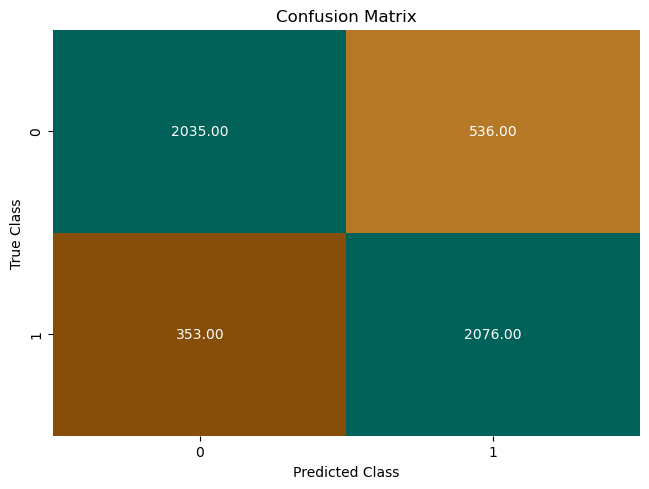

In [46]:
plot_confusion_matrix(test['label'], target_predicted_binary)

# 調用自訂函數輸出指標

提供真實值與預測值計算績效

In [47]:
print_metrics(
    test['label'], 
    target_predicted_binary
)

敏感性/召回率 (Sensitivity or TPR): 85.4672704816797%
特異性 (Specificity or TNR): 79.15208090237262%
精確率 (Precision): 79.47932618683001%
陰性預測值 (Negative Predictive Value): 85.2177554438861%
假陽性率 (False Positive Rate): 20.847919097627383%
假陰性率 (False Negative Rate): 14.532729518320298%
假發現率 (False Discovery Rate): 20.520673813169985%
正確率 (Accuracy): 82.22%


# 標準化文本

從 NLTK 庫獲取停用詞列表

In [48]:
stop = stopwords.words('english')

自訂函數更新停用詞列

In [49]:
def remove_stopwords(stopwords):
    # 特定停用詞
    excluding = ['against', 'not', 'don', 'don\'t', 'ain', 'are', 'aren\'t']

    # 定義需要排除的詞彙，這些詞將不會被視為停用詞
    excluding = [
        'against', 'not', 'don', 'don\'t', 'ain', 'are', 'aren\'t', 'could',
        'couldn\'t','did', 'didn\'t', 'does', 'doesn\'t', 'had', 'hadn\'t',
        'has', 'hasn\'t', 'have', 'haven\'t', 'is', 'isn\'t', 'might',
        'mightn\'t', 'must', 'mustn\'t', 'need', 'needn\'t', 'should',
        'shouldn\'t', 'was', 'wasn\'t', 'were', 'weren\'t', 'won\'t',
        'would', 'wouldn\'t'
    ]

    # 返回移除指定排除詞後的停用詞列表
    return [word for word in stop if word not in excluding]

# 更新後的停用詞列表
stopwords = remove_stopwords(stop)
stopwords[:5]

['i', 'me', 'my', 'myself', 'we']

# 詞幹還原

選用英文詞幹化

In [50]:
# SnowballStemmer 是 NLTK 的詞幹還原工具
snow = SnowballStemmer('english')

自定義清理函數

In [51]:
def clean(sent):
    # 將句子轉換為小寫，統一字母大小寫
    sent = sent.lower()
    
    # 使用正則表達式移除多餘的空白字符，將連續的空白轉為單一空格
    sent = re.sub('\s+', ' ', sent)
    
    ### 開始清理過程
    # 移除句首和句尾的空白字符
    sent = sent.strip()
    
    # 使用正則表達式移除 HTML 標籤，例如 `<tag>text</tag>` 會被替換為 `text`
    sent = re.compile('<.*?>').sub('', sent)
    ### 清理結束
    
    # 初始化一個空的列表，存儲經過篩選和詞幹化處理的單詞
    filtered_sentence = []
    
    # 使用 `word_tokenize` 將句子分割成單詞
    for w in word_tokenize(sent):
        # 這裡進行自定義的篩選：檢查該單詞是否符合以下條件：
        # 1. 不是數字
        # 2. 單詞長度大於 2 個字母
        # 3. 不在停用詞列表 `stopwords` 中
        if (not w.isnumeric()) and (len(w) > 2) and (w not in stopwords):  
            # 對符合條件的單詞進行詞幹化處理，並添加到 `filtered_sentence` 列表
            filtered_sentence.append(snow.stem(w))
    
    # 將處理後的單詞列表組合成最終的清理後字串，單詞間以空格分隔
    final_string = " ".join(filtered_sentence) 
    
    # 返回最終清理後的字串
    return final_string

# 觀察一下當前的 df

In [52]:
df

,text,label
0,What I hoped for (or even expected) was the we...,0
1,Garden State must rate amongst the most contri...,0
2,There is a lot wrong with this film. I will no...,1
3,"To qualify my use of ""realistic"" in the summar...",1
4,Dirty War is absolutely one of the best politi...,1
...,...,...
49995,"You do not get more dark or tragic than ""Othel...",1
49996,Wow probable the worst movie i have ever seen!...,0
49997,"Have not watched kids films for some years, so...",0
49998,"Pickup on South Street (1953), directed by mov...",1


為求謹慎，重新進行拆分

In [53]:
train, validate, test = split_data(df)

In [54]:
print(train.shape)
print(test.shape)
print(validate.shape)

(40000, 2)
(5000, 2)
(5000, 2)


# 建立管道

設定特徵與目標欄位

In [55]:
# 設定文本特徵的欄位名稱
text_features = ['text']
# 設定目標欄位名稱
model_target = 'label'

建立轉換管道

In [56]:
text_processor_0 = Pipeline([(
    # 命名任務
    'text_vect_0', 
    # 進行文本向量化，並使用 clean 函數作為預處理器
    CountVectorizer(
        preprocessor=clean, 
        max_features=500
    )
)])
text_processor_0

Pipeline(steps=[('text_vect_0',
                 CountVectorizer(max_features=500,
                                 preprocessor=<function clean at 0x7f0d59246b90>))])

定義數據處理的欄位轉換器

In [57]:
data_preprocessor = ColumnTransformer([(
    # 命名
    'text_pre_0',
    # 指定轉換管道，就是前一個步驟建立的
    text_processor_0, 
    # 要轉換的欄位名稱
    text_features[0]
)])
data_preprocessor

ColumnTransformer(transformers=[('text_pre_0',
                                 Pipeline(steps=[('text_vect_0',
                                                  CountVectorizer(max_features=500,
                                                                  preprocessor=<function clean at 0x7f0d59246b90>))]),
                                 'text')])

# 預處理前先觀察資料

In [58]:
print(
    'Datasets shapes before processing: ', 
    train.shape, 
    validate.shape, 
    test.shape
)

Datasets shapes before processing:  (40000, 2) (5000, 2) (5000, 2)


# 將資料集中的特徵進行轉換處理

轉換後的數據適用於模型訓練和評估

fit_transform 同時執行 `擬合和轉換`，transform 只進行 `轉換`，不再重新擬合

In [59]:
print(
    'Datasets shapes after processing: ', 
    train_matrix.shape, 
    validate_matrix.shape, 
    test_matrix.shape
)

Datasets shapes after processing:  (40000, 500) (5000, 500) (5000, 500)


# 上傳訓練數據至 S3 

定義上傳函數

In [60]:
# 建立 S3 的資源物件
s3_resource = boto3.Session().resource('s3')

# 自定義函數，處理數據轉換為 CSV 格式並上傳至 S3
def upload_s3_csv(filename, folder, X_train, y_train, is_test=False):
    # 建立一個內存中的字串緩衝區，用來暫存 CSV 內容
    csv_buffer = io.StringIO()
    
    # 將特徵數據轉換為浮點數列表
    # 這裡使用列表生成式，將 X_train 中的每個元素轉換為一維浮點數列表
    features = [t.toarray().astype('float32').flatten().tolist() for t in X_train]
    
    # 判斷是否為測試數據
    if is_test:
        # 如果是測試數據，則直接使用 features，不加入標籤數據
        temp_list = features
    else:
        # 如果是訓練數據，將標籤數據插入到每行特徵數據的第一個位置
        temp_list = np.insert(features, 0, y_train['label'], axis=1)
    
    # 將 temp_list 資料存入 CSV 格式，使用逗號作為分隔符
    np.savetxt(csv_buffer, temp_list, delimiter=',')

    # 使用 S3 資源物件上傳 CSV 文件到指定的 bucket 路徑
    # os.path.join 用來組合 prefix、folder 和 filename 為完整的 S3 路徑
    s3_resource.Bucket(bucket).Object(
        os.path.join(prefix, folder, filename)
    ).put(
        Body=csv_buffer.getvalue()  # 上傳緩衝區中的 CSV 資料
    )


INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


觀察並確認是否已取得 bucket 名稱

In [61]:
bucket, bucket_name

('c133864a3391494l8261467t1w211125745218-labbucket-l3pdqvsabmhi',
 'c133864a3391494l8261467t1w211125745218-labbucket-l3pdqvsabmhi')

# 定義路徑

prefix 部分之前已定義為 'lab41_new'

定義資料集文件名稱

In [62]:
train_file='train_pass2.csv'
validate_file='validate_pass2.csv'
test_file='test_pass2.csv'

# 上傳文件

In [63]:
upload_s3_csv(train_file, 'train', train_matrix, train)
upload_s3_csv(validate_file, 'validate', validate_matrix, validate)
upload_s3_csv(test_file, 'test', test_matrix, test, True)

查看當前 S3

In [64]:
list_s3_structure(bucket_name)

📁 lab41_new
    📁 batch-in
        📄 batch-in.csv
    📁 batch-out
        📄 batch-in.csv.out
    📁 output
        📁 xgb-pass1-11-13-2024-18-23-55
            📁 debug-output
                📁 collections
                    📁 000000000
                        📄 worker_0_collections.json
                📁 events
                    📁 000000000000
                        📄 000000000000_worker_0.tfevents
                    📁 000000000010
                        📄 000000000010_worker_0.tfevents
                    📁 000000000020
                        📄 000000000020_worker_0.tfevents
                    📁 000000000030
                        📄 000000000030_worker_0.tfevents
                    📁 000000000040
                        📄 000000000040_worker_0.tfevents
                📁 index
                    📁 000000000
                        📄 000000000000_worker_0.json
                        📄 000000000010_worker_0.json
                        📄 000000000020_worker_0.json
             

# 建立估計器

查看一下區域

In [65]:
boto3.Session().region_name

'us-east-1'

從 AWS Container Registry 取得指定版本的 XGBoost 容器映像

In [66]:
container = retrieve(
    'xgboost', 
    boto3.Session().region_name, 
    '1.0-1'
)

INFO:sagemaker.image_uris:Defaulting to only available Python version: py3
INFO:sagemaker.image_uris:Defaulting to only supported image scope: cpu.


# 定義 XGBoost 超參數

In [67]:
hyperparams = {
    # 設定 XGBoost 的訓練輪數為 42
    "num_round": "42",
    # 設定評估指標為錯誤率
    "eval_metric": "error",
    # 設定目標函數為二元分類（邏輯回歸）
    "objective": "binary:logistic",
    # 設定靜默模式，減少訓練過程中的輸出
    "silent": 1
}

# 建立估計器物件

並設定容器映像、執行角色、實例類型、輸出路徑等

In [68]:
xgb_model = sagemaker.estimator.Estimator(
    # 使用的 XGBoost 容器映像
    container,                            
    # 使用 SageMaker 執行所需的 IAM 角色
    sagemaker.get_execution_role(),       
    # 設定使用的實例數量為 1
    instance_count=1,
    # 設定使用的實例類型為 ml.m5.2xlarge
    instance_type='ml.m5.2xlarge',
    # 設定模型訓練輸出的 S3 路徑
    output_path=s3_output_location,
    # 設定 XGBoost 超參數
    hyperparameters=hyperparams,
    # 使用目前的 SageMaker session
    sagemaker_session=sagemaker.Session() 
)

建立通道

In [69]:
# 建立訓練資料通道，從 S3 載入訓練集 CSV 資料
train_channel = sagemaker.inputs.TrainingInput(
    f's3://{bucket}/{prefix}/train/{train_file}',  # 訓練資料的 S3 路徑
    content_type='text/csv'                        # 設定資料格式為 CSV
)

# 建立驗證資料通道，從 S3 載入驗證集 CSV 資料
validate_channel = sagemaker.inputs.TrainingInput(
    f's3://{bucket}/{prefix}/validate/{validate_file}', # 驗證資料的 S3 路徑
    content_type='text/csv'                             # 設定資料格式為 CSV
)

# 組合資料通道成為一個字典，分別包含訓練與驗證的資料
data_channels = {
    'train': train_channel,        # 訓練資料通道
    'validation': validate_channel # 驗證資料通道
}



# 開始訓練模型

In [70]:
xgb_model.fit(
    # 設定訓練與驗證的資料通道
    inputs=data_channels,                    
    # 設定不顯示訓練過程的日誌輸出
    logs=False,                              
    # 訓練作業名稱，包含時間戳
    job_name='xgb-pass2-' + datetime.now().strftime("%m-%d-%Y-%H-%M-%S")  
)

INFO:sagemaker:Creating training-job with name: xgb-pass2-11-13-2024-18-33-48



2024-11-13 18:33:52 Starting - Starting the training job..
2024-11-13 18:34:07 Starting - Preparing the instances for training.....
2024-11-13 18:34:35 Downloading - Downloading input data....
2024-11-13 18:35:00 Downloading - Downloading the training image....
2024-11-13 18:35:25 Training - Training image download completed. Training in progress......
2024-11-13 18:35:56 Uploading - Uploading generated training model.
2024-11-13 18:36:10 Completed - Training job completed


# 訓練績效

In [71]:
_analytics = sagemaker.analytics.TrainingJobAnalytics(
    xgb_model._current_job_name, 
    metric_names = ['train:error','validation:error']
)

In [72]:
_analytics

<sagemaker.TrainingJobAnalytics for xgb-pass2-11-13-2024-18-33-48>

In [73]:
_analytics.dataframe()

,timestamp,metric_name,value
0,0.0,train:error,0.20855
1,0.0,validation:error,0.23550


# 建立轉換器

In [74]:
xgb_transformer = xgb_model.transformer(
    instance_count=1,
    instance_type='ml.m5.2xlarge',
    strategy='MultiRecord',
    assemble_with='Line',
    output_path=batch_output
)

INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-13-18-36-10-456


# 執行轉換作業

In [75]:
xgb_transformer.transform(
    data=batch_input,
    data_type='S3Prefix',
    content_type='text/csv',
    split_type='Line'
)

INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-11-13-18-36-11-102


....................................
[2024-11-13:18:42:10:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-13:18:42:10:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-13:18:42:10:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-11-13 18:42:10 +0000] [27] [INFO] Startin

這段代碼是多餘的，在這個版本中並無作用，這裡僅做保留

In [76]:
xgb_transformer.wait(logs=False)

!


# 下載預測結果文件

查看 bucket

In [77]:
bucket

'c133864a3391494l8261467t1w211125745218-labbucket-l3pdqvsabmhi'

建立 Key

In [78]:
_key = "{}/batch-out/{}".format(prefix,'batch-in.csv.out')
_key

'lab41_new/batch-out/batch-in.csv.out'

# 取得數據

In [79]:
s3 = boto3.client('s3')
obj = s3.get_object(
    Bucket=bucket, 
    Key=_key
)

# 不指定欄位名稱，保留原始欄位名

In [80]:
target_predicted_original = pd.read_csv(io.BytesIO(obj['Body'].read()), sep=',')
target_predicted_original[0:5]

,0.8042524456977844
0,0.053819
1,0.601907
2,0.680756
3,0.800711
4,0.256345


必須再次讀取

In [81]:
s3 = boto3.client('s3')
obj = s3.get_object(
    Bucket=bucket, 
    Key=_key
)

讀取 CSV 文件並轉換為 Pandas DataFrame

In [82]:
target_predicted = pd.read_csv(
    io.BytesIO(obj['Body'].read()),
    sep=',',
    # 將列命名為 'class'
    names=['class']
)
target_predicted[:5]

,class
0,0.804252
1,0.053819
2,0.601907
3,0.680756
4,0.800711


# 自定義二元轉換函數

In [83]:
def binary_convert(x):
    threshold = 0.5
    if x > threshold:
        return 1
    else:
        return 0

將 'class' 列中的每個值應用 binary_convert 函數，並生成二元化的預測結果

In [84]:
target_predicted_binary = target_predicted['class'].apply(binary_convert)
target_predicted_binary[:5]

0    1
1    0
2    1
3    1
4    1
Name: class, dtype: int64

# 繪製混淆矩陣

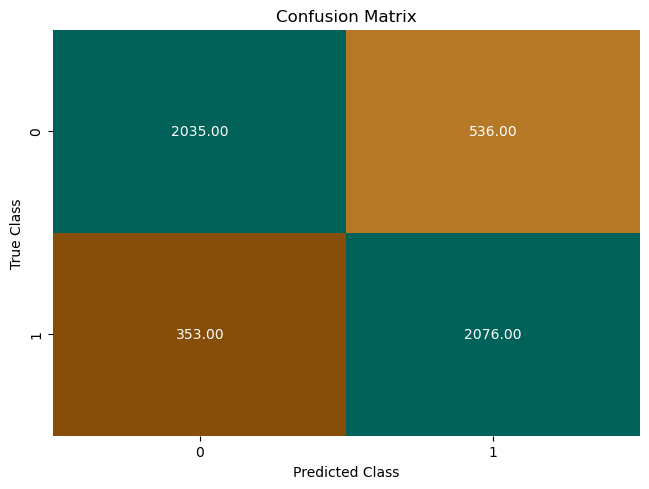

In [85]:
plot_confusion_matrix(test['label'], target_predicted_binary)

輸出績效指標

In [86]:
print_metrics(test['label'], target_predicted_binary)

敏感性/召回率 (Sensitivity or TPR): 85.4672704816797%
特異性 (Specificity or TNR): 79.15208090237262%
精確率 (Precision): 79.47932618683001%
陰性預測值 (Negative Predictive Value): 85.2177554438861%
假陽性率 (False Positive Rate): 20.847919097627383%
假陰性率 (False Negative Rate): 14.532729518320298%
假發現率 (False Discovery Rate): 20.520673813169985%
正確率 (Accuracy): 82.22%


# 調整超參數

目的是優化模型

查看角色

In [87]:
role_arn = sagemaker.get_execution_role()
role_arn

'arn:aws:iam::211125745218:role/service-role/c133864a3391494l8261467t1w21-SageMakerExecutionRole-99UPuQ18KetK'

設定輸出路徑

In [88]:
_output_path = f's3://{bucket}/{prefix}/output'
_output_path

's3://c133864a3391494l8261467t1w211125745218-labbucket-l3pdqvsabmhi/lab41_new/output'

# 設定訓練任務的配置配置

估計器就是一個訓練任務的配置

In [89]:
xgb = sagemaker.estimator.Estimator(
    container,
    role=role_arn, 
    instance_count= 1,
    instance_type='ml.m5.2xlarge', 
    output_path=_output_path,
    sagemaker_session=sagemaker.Session()
)

# 設定 XGBoost 模型的超參數

In [90]:
xgb.set_hyperparameters(
    # 設定評估指標為 'error'，即模型預測錯誤率
    eval_metric='error',
    # 設定目標函數為 'binary:logistic'，適用於二元分類的邏輯回歸
    objective='binary:logistic',
    # 設定模型訓練的迭代次數為 42
    num_round=42,
    # 設定 silent 參數為 1，以關閉訓練過程中的訊息輸出
    silent=1
)


# 定義模型超參數的範圍

導入庫

In [92]:
from sagemaker.tuner import (
    # 整數參數
    IntegerParameter, 
    # 類別參數
    CategoricalParameter, 
    # 連續參數
    ContinuousParameter, 
    # 超參數調優器
    HyperparameterTuner
)

範圍設定

In [93]:
# 初始的範例設定，為超參數 alpha 設定了一個連續範圍 [0, 1000]
hyperparameter_ranges = {'alpha': ContinuousParameter(0,1000)}

# 擴展範圍設定
hyperparameter_ranges = {
    'alpha': ContinuousParameter(0, 1000),
    'min_child_weight': ContinuousParameter(0, 120),
    'subsample': ContinuousParameter(0.5, 1),
    'eta': ContinuousParameter(0.1, 0.5),  
    'num_round': IntegerParameter(1,4000)
}

# 指定目標指標

包含目標度量 (objective_metric_name) 和優化目標 (objective_type)

假設要將模型的驗證錯誤（validation:error）最小化，可設定如下

In [94]:
objective_metric_name = 'validation:error'
objective_type = 'Minimize'

# 建立自動調優超參數的 HyperparameterTuner 物件

In [95]:
tuner = HyperparameterTuner(
    # 指定要調優的模型是 XGBoost 模型
    xgb,
    # 設定調優的目標度量名稱，根據此度量判斷模型優劣
    objective_metric_name,
    # 定義超參數的範圍，允許調優器在範圍內搜尋最佳參數
    hyperparameter_ranges,
    # 最大調優作業數，控制調優過程中的總實驗次數，取決於時間和資金的需求，設為 10 或更高
    max_jobs=10,
    # 最大並行作業數，控制同時執行的實驗數量，設為 1 表示逐次進行
    max_parallel_jobs=1,
    # 定義目標類型，例如 Minimize 或 Maximize，以指示優化方向
    objective_type=objective_type,
    # 設定早停類型為自動，若調優過程中無法提升性能會自動停止
    early_stopping_type='Auto',
)


# 查看通道

In [97]:
data_channels

{'train': <sagemaker.inputs.TrainingInput at 0x7f0d540c7cd0>,
 'validation': <sagemaker.inputs.TrainingInput at 0x7f0d540c5000>}

# 開始訓練

運行後會出現警告，顯示在建立超參數調優作業時，沒有找到與該估計器相關聯且完成訓練的工作，也就是估計器尚未執行過任何訓練，這會讓估計器沒有訓練紀錄可以參考而出現警告。

In [96]:
tuner.fit(
    inputs=data_channels,
    include_cls_metadata=False,
    wait=False
)

INFO:sagemaker:Creating hyperparameter tuning job with name: sagemaker-xgboost-241113-1909


# 等待任務完成

In [98]:
tuner.wait()

.................................................................................................................................................................................!


導入庫

In [99]:
from pprint import pprint
from sagemaker.analytics import HyperparameterTuningJobAnalytics

查詢最近一次任務

In [100]:
_latest_tuning_job_name = tuner.latest_tuning_job.name
_latest_tuning_job_name

'sagemaker-xgboost-241113-1909'

建立超參優化分析器物件，這是用於分析調優任務的數據

In [101]:
tuner_analytics = HyperparameterTuningJobAnalytics(
    # 是最近一次調優任務的名稱
    _latest_tuning_job_name, 
    # 指定要使用的 SageMaker 任務
    sagemaker_session=sagemaker.Session()
)

顯示為 dataframe

In [102]:
df_tuning_job_analytics = tuner_analytics.dataframe()
df_tuning_job_analytics[:5]

,alpha,eta,min_child_weight,num_round,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.000000,0.191097,77.727251,947.0,0.772401,sagemaker-xgboost-241113-1909-010-54b73bd9,Completed,0.1590,2024-11-13 19:23:24+00:00,2024-11-13 19:26:44+00:00,200.0
1,256.396860,0.145933,26.647160,162.0,0.834758,sagemaker-xgboost-241113-1909-009-0bf1a732,Completed,0.1976,2024-11-13 19:22:10+00:00,2024-11-13 19:23:04+00:00,54.0
2,0.000000,0.322926,25.164994,113.0,0.500000,sagemaker-xgboost-241113-1909-008-a3a57cc1,Completed,0.1694,2024-11-13 19:20:59+00:00,2024-11-13 19:21:53+00:00,54.0
3,0.000000,0.119524,29.661496,292.0,1.000000,sagemaker-xgboost-241113-1909-007-0c4e60eb,Completed,0.1626,2024-11-13 19:19:22+00:00,2024-11-13 19:20:42+00:00,80.0
4,602.806938,0.284673,37.496072,6.0,0.636786,sagemaker-xgboost-241113-1909-006-f5cd8df6,Completed,0.2706,2024-11-13 19:17:23+00:00,2024-11-13 19:18:49+00:00,86.0
5,370.447581,0.132377,5.405658,1385.0,0.913307,sagemaker-xgboost-241113-1909-005-7d917cbb,Stopped,0.2136,2024-11-13 19:15:38+00:00,2024-11-13 19:16:39+00:00,61.0
6,619.377946,0.281090,25.949334,7.0,0.975393,sagemaker-xgboost-241113-1909-004-af31b916,Completed,0.2614,2024-11-13 19:14:47+00:00,2024-11-13 19:15:23+00:00,36.0
7,963.191355,0.389268,13.639865,356.0,0.747090,sagemaker-xgboost-241113-1909-003-2b6c374c,Completed,0.2532,2024-11-13 19:13:42+00:00,2024-11-13 19:14:36+00:00,54.0
8,124.092174,0.267298,30.316237,1.0,0.771243,sagemaker-xgboost-241113-1909-002-30eb7ad5,Completed,0.3022,2024-11-13 19:12:55+00:00,2024-11-13 19:13:29+00:00,34.0
9,166.716829,0.290323,100.073059,512.0,0.789296,sagemaker-xgboost-241113-1909-001-0cff04d6,Completed,0.1770,2024-11-13 19:10:12+00:00,2024-11-13 19:12:25+00:00,133.0


# 將 DataFrame 進行排序

In [103]:
# Sort the tuning job analytics by the final metrics value
df_tuning_job_analytics.sort_values(
    # 以此列為排序依據
    by=['FinalObjectiveValue'],
    # 直接在原數據上進行排序，不會傳回新的 DataFrame
    inplace=True,
    # 如果目標是 "Maximize" 則降序排列，否則升序排列
    ascending=False if tuner.objective_type == "Maximize" else True)

# 顯示前 20 筆調優分析數據

In [104]:
df_tuning_job_analytics.head(20)

,alpha,eta,min_child_weight,num_round,subsample,TrainingJobName,TrainingJobStatus,FinalObjectiveValue,TrainingStartTime,TrainingEndTime,TrainingElapsedTimeSeconds
0,0.000000,0.191097,77.727251,947.0,0.772401,sagemaker-xgboost-241113-1909-010-54b73bd9,Completed,0.1590,2024-11-13 19:23:24+00:00,2024-11-13 19:26:44+00:00,200.0
3,0.000000,0.119524,29.661496,292.0,1.000000,sagemaker-xgboost-241113-1909-007-0c4e60eb,Completed,0.1626,2024-11-13 19:19:22+00:00,2024-11-13 19:20:42+00:00,80.0
2,0.000000,0.322926,25.164994,113.0,0.500000,sagemaker-xgboost-241113-1909-008-a3a57cc1,Completed,0.1694,2024-11-13 19:20:59+00:00,2024-11-13 19:21:53+00:00,54.0
9,166.716829,0.290323,100.073059,512.0,0.789296,sagemaker-xgboost-241113-1909-001-0cff04d6,Completed,0.1770,2024-11-13 19:10:12+00:00,2024-11-13 19:12:25+00:00,133.0
1,256.396860,0.145933,26.647160,162.0,0.834758,sagemaker-xgboost-241113-1909-009-0bf1a732,Completed,0.1976,2024-11-13 19:22:10+00:00,2024-11-13 19:23:04+00:00,54.0
5,370.447581,0.132377,5.405658,1385.0,0.913307,sagemaker-xgboost-241113-1909-005-7d917cbb,Stopped,0.2136,2024-11-13 19:15:38+00:00,2024-11-13 19:16:39+00:00,61.0
7,963.191355,0.389268,13.639865,356.0,0.747090,sagemaker-xgboost-241113-1909-003-2b6c374c,Completed,0.2532,2024-11-13 19:13:42+00:00,2024-11-13 19:14:36+00:00,54.0
6,619.377946,0.281090,25.949334,7.0,0.975393,sagemaker-xgboost-241113-1909-004-af31b916,Completed,0.2614,2024-11-13 19:14:47+00:00,2024-11-13 19:15:23+00:00,36.0
4,602.806938,0.284673,37.496072,6.0,0.636786,sagemaker-xgboost-241113-1909-006-f5cd8df6,Completed,0.2706,2024-11-13 19:17:23+00:00,2024-11-13 19:18:49+00:00,86.0
8,124.092174,0.267298,30.316237,1.0,0.771243,sagemaker-xgboost-241113-1909-002-30eb7ad5,Completed,0.3022,2024-11-13 19:12:55+00:00,2024-11-13 19:13:29+00:00,34.0


# 使用最佳超參數作業

調優作業完成後，可從 HyperparameterTuner 物件中找到最佳的調優作業

In [107]:
# 附加到最近一次的調優任務
attached_tuner = HyperparameterTuner.attach(
    # 指定要附加的任務是最新的調優任務
    _latest_tuning_job_name, 
    # 指定 SageMaker 任務
    sagemaker_session=sagemaker.Session()
)
best_training_job = attached_tuner.best_training_job()

最佳訓練任務名稱

In [108]:
best_training_job

'sagemaker-xgboost-241113-1909-010-54b73bd9'

In [109]:
from sagemaker.estimator import Estimator

# 最佳訓練任務的名稱，該名稱在前面步驟取得
algo_estimator = Estimator.attach(best_training_job)


2024-11-13 19:26:47 Starting - Found matching resource for reuse
2024-11-13 19:26:47 Downloading - Downloading the training image
2024-11-13 19:26:47 Training - Training image download completed. Training in progress.
2024-11-13 19:26:47 Uploading - Uploading generated training model
2024-11-13 19:26:47 Completed - Resource released due to keep alive period expiry


# 使用最佳訓練任務的估計器建立一個模型

In [110]:
best_algo_model = algo_estimator.create_model(
    # 指定模型的環境變量
    env={'SAGEMAKER_DEFAULT_INVOCATIONS_ACCEPT':"text/csv"}
)

# 測試模型

從 scikit-learn 中導入文本特徵提取器、管道和欄位轉換器

In [111]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# 定義欄位名稱

In [112]:
# 文本特徵
text_features = ['text']
# 目標變量
model_target = 'label'

# 建立文本的管道

In [114]:
text_processor_0 = Pipeline([(
    'text_vect_0', 
    CountVectorizer(
        # 在分詞前先應用 `clean` 函數進行數據清洗
        preprocessor=clean, 
        # 進行文本特徵提取，並限制最多 500 個特徵
        max_features=500
    )
)])
text_processor_0

Pipeline(steps=[('text_vect_0',
                 CountVectorizer(max_features=500,
                                 preprocessor=<function clean at 0x7f0d59246b90>))])

# 將處理器應用於指定的文本欄位

就是 'text' 欄位

In [115]:
data_preprocessor = ColumnTransformer([
    ('text_pre_0', text_processor_0, text_features[0])
])
data_preprocessor

ColumnTransformer(transformers=[('text_pre_0',
                                 Pipeline(steps=[('text_vect_0',
                                                  CountVectorizer(max_features=500,
                                                                  preprocessor=<function clean at 0x7f0d59246b90>))]),
                                 'text')])

輸出

In [116]:
print(
    'Datasets shapes before processing: ', 
    train.shape, 
    validate.shape, 
    test.shape
)

Datasets shapes before processing:  (40000, 2) (5000, 2) (5000, 2)


# 使用預處理轉換器

In [ ]:
# 進行擬合並轉換數據
train_matrix = data_preprocessor.fit_transform(train)
# 只進行轉換而不重新擬合，適用於測試和驗證數據
test_matrix = data_preprocessor.transform(test)
validate_matrix = data_preprocessor.transform(validate)

# 輸出處理後的數據集形狀
print(
    'Datasets shapes after processing: ', 
    train_matrix.shape, 
    validate_matrix.shape, 
    test_matrix.shape
)